In [33]:
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import functional
from dataset import normalize, minmaxnorm
from scipy import interpolate
import random
from skimage.exposure import match_histograms

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/anacis/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot', 'hist', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [68]:
def fft2c(tensor):
    tensor = torch.fft.ifftshift(tensor, dim=(-2, -1))
    tensor = torch.fft.fft2(tensor)
    return torch.fft.fftshift(tensor, dim=(-2, -1))


def ifft2c(tensor):
    tensor = torch.fft.ifftshift(tensor, dim=(-2, -1))
    tensor = torch.fft.ifft2(tensor)
    return torch.fft.fftshift(tensor, dim=(-2, -1))


def ifft1c(tensor, dim=-1):
    tensor = torch.fft.ifftshift(tensor, dim=dim)
    tensor = torch.fft.ifft(tensor, dim=dim)
    return torch.fft.fftshift(tensor, dim=dim)


def fft1c(tensor, dim=-1):
    tensor = torch.fft.ifftshift(tensor, dim=dim)
    tensor = torch.fft.fft(tensor, dim=dim)
    return torch.fft.fftshift(tensor, dim=dim)

def get_mapping():
    kspace = torch.rand((1000, 1000,), dtype=torch.complex64) - 0.5 - 0.5j
    kx = torch.linspace(-1, 1, 1000)
    exp = torch.exp(-torch.sqrt(kx**2)/0.005)
    mapping = ifft1c(kspace * exp[None], dim=-1).real
#     mapping = torch.linspace(0, 1, 500)
#     mapping = torch.cat([mapping, mapping])[None]
    mapping -= torch.amin(mapping, dim=-1, keepdim=True)
    mapping /= torch.amax(mapping, dim=-1, keepdim=True)
#     plt.plot(torch.linspace(0, 1, 1000), mapping[0])
    #question why are we using mapping[0]?
    return mapping

In [69]:
def map_image(img, mapping):
    shape = img.shape
    img = img.reshape(-1, 1)
    f = interpolate.interp1d(torch.linspace(0, 1, 1000), mapping[0])
    new_img = f(img).reshape(shape)
    
    return new_img

def plot(img, new_img, img_norm, new_img_norm, hist_norm):
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))
    
    axs[0].imshow(img_norm, cmap='gray')
    axs[0].set_aspect('equal', 'box')
    axs[0].set_title("Original")
    
    axs[1].imshow(new_img_norm,  cmap='gray')
    axs[1].set_aspect('equal', 'box')
    axs[1].set_title("Augmented")
    
    axs[2].imshow(hist_norm,  cmap='gray')
    axs[2].set_aspect('equal', 'box')
    axs[2].set_title("Augmented with Hist Matching")
    
    axs[3].plot(torch.linspace(0, 1, 1000), mapping[0])
    axs[3].plot(img, new_img, 'r+')
    axs[3].set_aspect('equal', 'box')
    axs[3].set_title("Mapping")
    

In [70]:
def load_img(path):
    im = np.load(path)
    im = torch.from_numpy(im)
    return im
def get_patch(im, center):
    im = minmaxnorm(torch.abs(im).float())
    patch = im[center[0] - 47//2:center[0] + 47//2+1, center[1] - 47//2:center[1] + 47//2+1]     
    return patch

In [71]:
get_mapping().shape

torch.Size([1000, 1000])

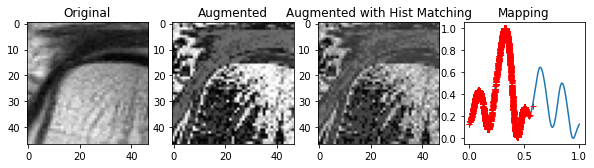

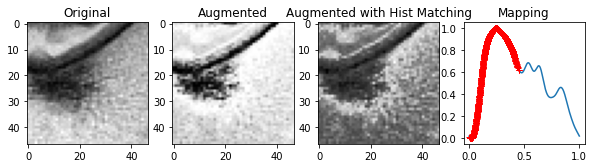

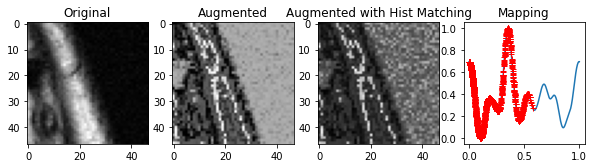

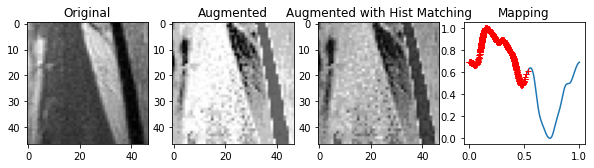

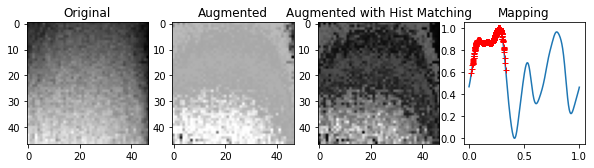

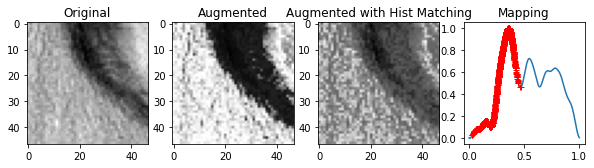

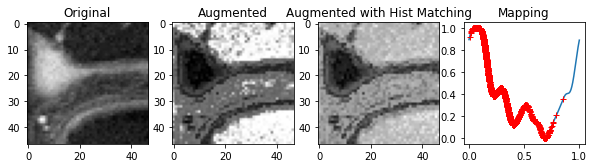

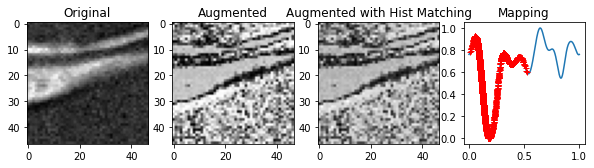

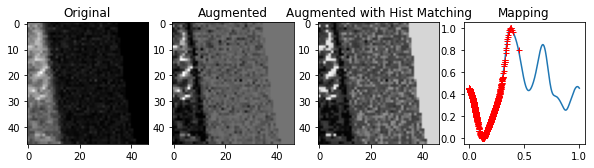

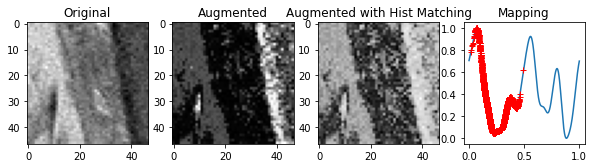

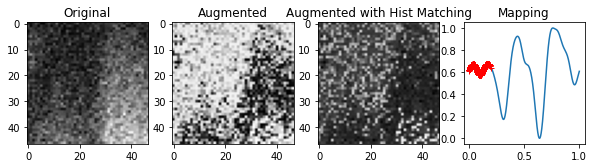

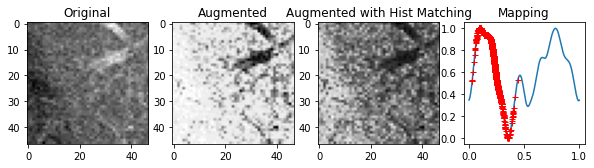

In [72]:
#Load 2 example images
input_paths = [
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
        ]
patch_centers = [(300, 120), (310, 200), (280, 290),
                         (450, 120), (95, 180), (200, 220)]

#Comparison of patch against augmentations

for path in input_paths:
    im = load_img(path)
    for center in patch_centers:
        #data preprocessing
        patch = get_patch(im, center)
     
        #get mapping
        mapping = get_mapping()
        
        #map image
        mapped = map_image(patch, mapping)
        
        #select another image
        img_idx = random.randint(0, len(input_paths))
        center_idx = random.randint(0, len(patch_centers))
        other_im = load_img(input_paths[img_idx])
        other_center = patch_centers[center_idx]
        other_patch = get_patch(other_im, other_center).detach().numpy()
        
        #make the new mapped image match the histogram of the other image
        hist = match_histograms(mapped, other_patch)
        
        #normalize everything
        img_norm = minmaxnorm(patch)
        new_img_norm = torch.from_numpy(mapped)
        hist_norm = torch.from_numpy(hist)
        
        #plot
        plot(patch, mapped, img_norm, new_img_norm, hist_norm)

(array([  4.,   1.,   1.,   3.,  12.,  13.,  12.,  22.,  23.,  33.,  38.,
         60.,  60.,  70.,  82., 132., 114., 130., 160., 174., 173., 154.,
        133., 115.,  95.,  84.,  63.,  44.,  36.,  40.,  22.,  20.,  12.,
          9.,  14.,   5.,  10.,   3.,   9.,   2.,   2.,   6.,   0.,   3.,
          8.,   1.,   1.,   0.,   0.,   1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

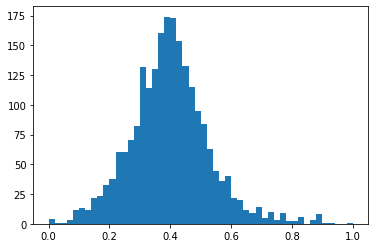

In [5]:
plt.hist(torch.abs(patch).numpy().flatten(), bins=50)   